<a href="https://colab.research.google.com/github/SushSushmithagowda/ML-101-projects/blob/main/Pneumonia%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import os

In [ ]:
!unzip gdrive/MyDrive/pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
!ls chest_xray

chest_xray  __MACOSX  test  train  val


In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/chest_xray/train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['NORMAL' 'PNEUMONIA']


In [ ]:
len(os.listdir("/content/chest_xray/train/NORMAL"))

1341

In [ ]:
len(os.listdir("/content/chest_xray/train/PNEUMONIA"))

3875

In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (1159, 1697)


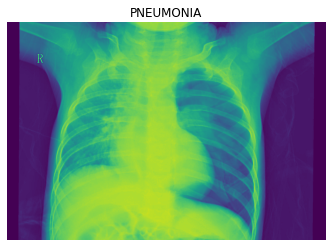

In [ ]:
img = view_random_image(target_dir='chest_xray/train/',target_class='PNEUMONIA')

In [ ]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
img.shape

(1159, 1697)

In [ ]:
img/255.

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
  padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid"), # binary activation output
  ])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/5
163/163 [==============================] - 79s 424ms/step - loss: 0.3063 - accuracy: 0.8737 - val_loss: 0.8172 - val_accuracy: 0.7260
Epoch 2/5
163/163 [==============================] - 69s 420ms/step - loss: 0.1137 - accuracy: 0.9576 - val_loss: 0.9076 - val_accuracy: 0.7260
Epoch 3/5
163/163 [==============================] - 69s 420ms/step - loss: 0.0949 - accuracy: 0.9645 - val_loss: 0.7926 - val_accuracy: 0.7564
Epoch 4/5
163/163 [==============================] - 68s 416ms/step - loss: 0.0760 - accuracy: 0.9699 - val_loss: 0.8026 - val_accuracy: 0.7724
Epoch 5/5
163/163 [==============================] - 67s 414ms/step - loss: 0.0596 - accuracy: 0.9772 - val_loss: 1.1795 - val_accuracy: 0.7532


In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
163/163 [==============================] - 63s 383ms/step - loss: 0.8064 - accuracy: 0.7337 - val_loss: 0.6682 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 62s 381ms/step - loss: 0.6123 - accuracy: 0.7429 - val_loss: 0.6622 - val_accuracy: 0.6250
Epoch 3/5
163/163 [==============================] - 61s 375ms/step - loss: 0.5828 - accuracy: 0.7429 - val_loss: 0.6725 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 62s 382ms/step - loss: 0.5727 - accuracy: 0.7429 - val_loss: 0.6843 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 63s 384ms/step - loss: 0.5705 - accuracy: 0.7429 - val_loss: 0.6906 - val_accuracy: 0.6250


In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
163/163 [==============================] - 84s 509ms/step - loss: 1.4405 - accuracy: 0.7928 - val_loss: 0.4380 - val_accuracy: 0.8109
Epoch 2/5
163/163 [==============================] - 65s 398ms/step - loss: 0.2044 - accuracy: 0.9212 - val_loss: 1.0873 - val_accuracy: 0.7147
Epoch 3/5
163/163 [==============================] - 62s 384ms/step - loss: 0.2075 - accuracy: 0.9233 - val_loss: 0.4391 - val_accuracy: 0.8253
Epoch 4/5
163/163 [==============================] - 62s 379ms/step - loss: 0.2485 - accuracy: 0.9139 - val_loss: 1.0742 - val_accuracy: 0.7067
Epoch 5/5
163/163 [==============================] - 61s 377ms/step - loss: 0.1857 - accuracy: 0.9304 - val_loss: 0.8100 - val_accuracy: 0.6987


In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Image shape: (951, 1310)
Image shape: (960, 1416)


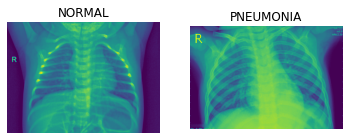

In [ ]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
normal_img = view_random_image("/content/chest_xray/train/", "NORMAL")
plt.subplot(1, 2, 2)
pneumonia_img = view_random_image("/content/chest_xray/train/", "PNEUMONIA")

In [ ]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [ ]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.01568628, 0.01568628, 0.01568628],
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471],
          ...,
          [0.03921569, 0.03921569, 0.03921569],
          [0.03921569, 0.03921569, 0.03921569],
          [0.03921569, 0.03921569, 0.03921569]],
 
         [[0.00784314, 0.00784314, 0.00784314],
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471],
          ...,
          [0.03137255, 0.03137255, 0.03137255],
          [0.03137255, 0.03137255, 0.03137255],
          [0.03137255, 0.03137255, 0.03137255]],
 
         [[0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          ...,
          [0.02745098, 0.02745098, 0.02745098],
          [0.02745098, 0.02745098, 0.02745098],
          [0.03137255, 0.03137255, 0.03137255]],
 
         ...,
 
         [[0.05882353, 0.05882353, 0.05882353],
          [0.05490

In [ ]:
# View the first batch of labels
labels

array([1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [ ]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

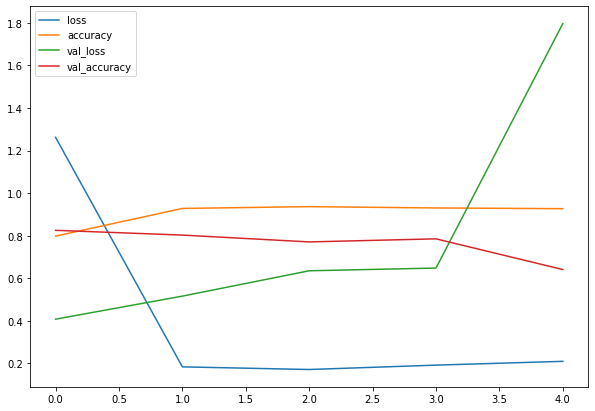

In [ ]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_3.history).plot(figsize=(10, 7));

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

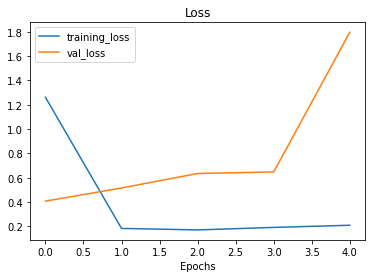

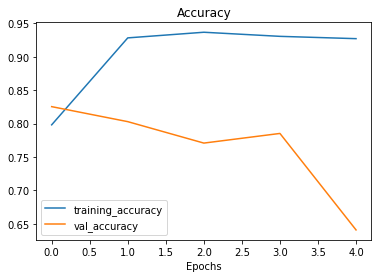

In [ ]:
# Check out the loss curves of model_4
plot_loss_curves(history_3)

In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.MaxPool2D(pool_size=2), # reduce number of features by half
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [ ]:
# Compile model (same as model_4)
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
163/163 [==============================] - 63s 383ms/step - loss: 0.2835 - accuracy: 0.8802 - val_loss: 0.5290 - val_accuracy: 0.7901
Epoch 2/5
163/163 [==============================] - 62s 380ms/step - loss: 0.1083 - accuracy: 0.9613 - val_loss: 0.9916 - val_accuracy: 0.7163
Epoch 3/5
163/163 [==============================] - 62s 380ms/step - loss: 0.0966 - accuracy: 0.9653 - val_loss: 0.9833 - val_accuracy: 0.7452
Epoch 4/5
163/163 [==============================] - 62s 377ms/step - loss: 0.0850 - accuracy: 0.9693 - val_loss: 0.5526 - val_accuracy: 0.7917
Epoch 5/5
163/163 [==============================] - 63s 385ms/step - loss: 0.0714 - accuracy: 0.9737 - val_loss: 0.6555 - val_accuracy: 0.7965


In [ ]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

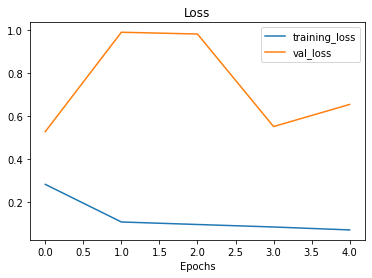

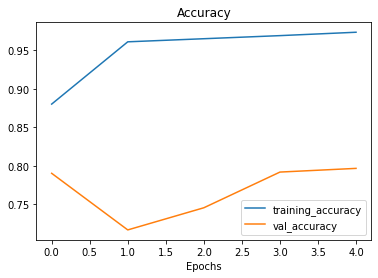

In [ ]:
# Plot loss curves of model_5 results
plot_loss_curves(history_4)

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 5216 images belonging to 2 classes.
Non-augmented training images:
Found 5216 images belonging to 2 classes.
Unchanged test images:
Found 624 images belonging to 2 classes.


In [ ]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

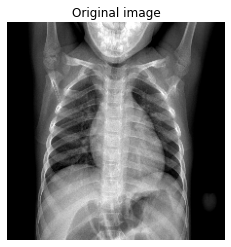

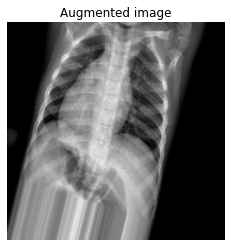

In [ ]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [ ]:
# Create the model (same as model_5)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_5 = model_5.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_5)

In [ ]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

In [ ]:
# Create the model (same as model_5 and model_6)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_6 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(128, 3, activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0.25),
  tf.keras.layers.Dropout(0.25),
  
  tf.keras.layers.Conv2D(96, 3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0),

  tf.keras.layers.Conv2D(72, 3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0.25),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Conv2D(64, 3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0.25),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(48, 3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0.25),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(36, 3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0),

  tf.keras.layers.Conv2D(24, 3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0.25),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(12, 3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0),

  tf.keras.layers.Conv2D(4, 3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0.25),
  tf.keras.layers.Dropout(0.25),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0),

  tf.keras.layers.Dense(256),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0.25),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Dense(96),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0),

  tf.keras.layers.Dense(32),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(alpha=0.25),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Dense(10),
  tf.keras.layers.Activation(tf.keras.activations.softmax),
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

cb1 = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_acc')
cb2 = ReduceLROnPlateau(patience=3, monitor='val_acc')

# Fit the model
history_6 = model_6.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=10,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data, callbacks=[cb1, cb2])

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

In [ ]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_7 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3), kernel_regularizer = tf.keras.regularizers.l2(l=0.01)), # same input shape as our images
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3), kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),
])

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data), callbacks = [early_stopping])

In [ ]:
model_7.summary()

In [ ]:
# Check out the TinyVGG model performance
plot_loss_curves(history_7)

In [ ]:
print(class_names)

In [ ]:
test_image = mpimg.imread('/content/NORMAL2-IM-0337-0001.jpeg')

In [ ]:
plt.imshow(test_image)
plt.axis(False);

In [ ]:
test_image.shape

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
test_image = load_and_prep_image("/content/NORMAL2-IM-0337-0001.jpeg")
test_image

In [ ]:
model_7.predict(test_image)

In [ ]:
# Add an extra axis
print(f"Shape before new dimension: {test_image.shape}")
test_image = tf.expand_dims(test_image, axis=0) # add an extra dimension at axis 0
#test_image = test_image[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {test_image.shape}")
test_image


In [ ]:
# Make a prediction on custom image tensor
pred = model_7.predict(test_image)
pred

In [ ]:
pred

In [ ]:
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
# Test our model on a custom image
pred_and_plot(model_7, "/content/NORMAL2-IM-0337-0001.jpeg", class_names)

In [ ]:
pred_and_plot(model_7, "/content/person1_virus_6.jpeg", class_names)

In [ ]:
pred_and_plot(model_7, "/content/person30_virus_69.jpeg", class_names)

In [ ]:
pred_and_plot(model_7, "/content/NORMAL2-IM-0246-0001-0002.jpeg", class_names)